# QA Data Validation Sandbox (Python + Pandas)

This notebook demonstrates a practical, **QA-focused workflow** for validating a small regression-style dataset (actual vs predicted values). 

The objective is not to build a perfect model, but to show how data can be **inspected, cleaned, and monitored** using simple,
transparent quality checks.

### What this notebook covers
- Basic structural checks (shape, missing values, duplicates)
- Detection of invalid or inconsistent values (empty strings, type corruption, infinities, non-numeric entries)
- Conversion to numeric and statistical profiling with `describe()`
- Outlier detection using both rule-based range checks and IQR-based thresholds
- Calculation of error metrics (MAE, RMSE)
- Visual inspection of model behavior via scatter plots
- Early and late QA checks that encode expectations about data quality

#### Note
Several checks in this notebook are surfaced as **soft warnings** rather than hard assertions so the demonstration can run end-to-end. In real QA or data pipeline environments, many of these checks would typically be implemented as assertions or monitoring thresholds that can halt execution or raise alerts when violated.

In [3]:
import pandas as pd  # for DataFrame manipulations
import numpy as np  # for numerical operations
import matplotlib.pyplot as plt  # for plotting
import sys  # to modify sys.path
from pathlib import Path  # to handle file paths

# Add parent directory to sys.path
notebook_dir = Path.cwd()  # current working directory (`notebooks`)
project_root = notebook_dir.parent  # parent directory (`qa-data-validation-sandbox`)

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))  # add project root to sys.path

# Our reusable helper functions
from src.data_validation_utils import (
    validate_numeric_column,
    values_out_of_range_with_reason,
    iqr_outliers,
    iqr_outlier_fraction,
    compute_mae_rmse,
)

# Set pandas display option for floating point numbers - two decimal places
pd.set_option("display.float_format", lambda x: f"{x:0.2f}")

# Ensures reproducible synthetic data - same every time we run the notebook
np.random.seed(42)

---

## 1. Create synthetic dataset

We simulate a regression-like problem with:

- `actual_value`: ground-truth values around 100.
- `predicted_value`: model predictions around 100, with slightly higher noise.

Each row is identified by an `id`.

**NOTE:** Synthetic data is used so the notebook remains self-contained and safe to publish.

In [5]:
# The number of rows in our dataset
size = 50

# Create a DataFrame with actual and predicted values (synthetic normal data)
# - actual values: distributed around 100 with a standard deviation of 10
# - predicted values: around 100 with a standard deviation of 12
df = pd.DataFrame({
    "id": range(1, size + 1),
    "actual_value": np.random.normal(loc=100, scale=10, size=size), # mean=100, std=10
    "predicted_value": np.random.normal(loc=100, scale=12, size=size), # mean=100, std=12
})

df.head(15)

,id,actual_value,predicted_value
0,1,104.97,103.89
1,2,98.62,95.38
2,3,106.48,91.88
3,4,115.23,107.34
4,5,97.66,112.37
5,6,97.66,111.18
6,7,115.79,89.93
7,8,107.67,96.29
8,9,95.31,103.98
9,10,105.43,111.71


### Inject intentional data issues

We intentionally inject a small, controlled set of issues so that downstream checks (missing values, invalid types, outliers, and default coercions) have something to detect. This makes the QA validation steps meaningful and demonstrable. As a result, we inject the following intentional issues:

- missing value
- empty string
- non-numeric text
- boolean
- infinity
- an extreme outlier
- a duplicate row

**Note:** To avoid pandas warnings/errors about dtype changes, we intentionally cast `actual_value` and `predicted_value` to `object` before injecting corrupted values.

In [7]:
# Explicitly allow mixed / corrupted types for demo injection (object = generic Python type)
df = df.astype({"actual_value": "object", "predicted_value": "object"})

# Missing predicted_value (null)
df.loc[5, "predicted_value"] = None

# Empty string in actual_value (type corruption)
df.loc[6, "actual_value"] = ""

# Boolean in predicted_value (wrong type)
df.loc[7, "predicted_value"] = False

# Infinity in predicted_value
df.loc[8, "predicted_value"] = np.inf

# Text in actual_value (non-numeric)
df.loc[9, "actual_value"] = "text"

# Extreme outlier in actual_value
df.loc[10, "actual_value"] = 9999

# Duplicate a row
duplicate_row = df.iloc[[2]]
df = pd.concat([df, duplicate_row], ignore_index=True)

df.tail(10)

,id,actual_value,predicted_value
41,42,101.71,111.62
42,43,98.84,91.58
43,44,96.99,96.07
44,45,85.21,95.29
45,46,92.80,82.44
46,47,95.39,103.55
47,48,110.57,103.13
48,49,103.44,100.06
49,50,82.37,97.18
50,3,106.48,91.88


---

## 2. Early QA assertions (schema & completeness)

Before running any analysis, we add a small set of assertions that encode
basic expectations about the dataset:

- required columns must be present
- the dataset must not be empty
- missing values (as reported in the raw data) should stay below a simple threshold
- after coercion to numeric, the fraction of unusable values should also be reasonable

These are examples of expectations that might be enforced on incoming data in a QA or data validation context.

With basic expectations validated, we now proceed to deeper column-level checks using reusable helper functions.

**Important notes (demo vs real world):**

- **Schema checks** and **raw missingness** use **hard assertions**, because these failures usually indicate structural problems with the dataset and should stop execution.
- **Numeric coercion checks** use **soft warnings** instead of hard assertions. This is **intentional for the demo**, because we injected non-numeric values on purpose. In a real data pipeline, these thresholds would typically be assertions that can fail a job.

In [9]:
print("\n=== EARLY QA ASSERTIONS ===\n")

# -----------------------------------------------------
# 1) Schema / structure checks
# -----------------------------------------------------
required_cols = {"actual_value", "predicted_value"}
missing_cols = required_cols - set(df.columns)
assert not missing_cols, f"Missing required columns: {missing_cols}"

assert len(df) > 0, "Dataset is empty." # assert non-empty dataset

# -----------------------------------------------------
# 2) Raw missingness
# -----------------------------------------------------
# NOTE: use `mean()` on boolean Series to get proportion of True values
# e.g. mean = (1+0+1+0) / 4 = 0.5 → 50% missing
missing_actual_raw = df["actual_value"].isna().mean()
missing_pred_raw = df["predicted_value"].isna().mean()

# percentages relate to proportions of total rows
max_missing_actual = 0.05  # 5%
max_missing_pred = 0.10    # 10%

assert missing_actual_raw <= max_missing_actual, \
    f"Too many raw missing actual values: {missing_actual_raw:0.2%} (limit {max_missing_actual:0.2%})"

assert missing_pred_raw <= max_missing_pred, \
    f"Too many raw missing predicted values: {missing_pred_raw:0.2%} (limit {max_missing_pred:0.2%})"

# -----------------------------------------------------
# 3) Numeric usability (after coercion)
# -----------------------------------------------------
# Coerce to numeric, forcing non-numeric values to NaN
numeric_actual = pd.to_numeric(df["actual_value"], errors="coerce")
numeric_pred = pd.to_numeric(df["predicted_value"], errors="coerce")

# NOTE: use `mean()` on boolean Series to get proportion of True values
# e.g. mean = (1+0+1+0) / 4 = 0.5 → 50% missing
numeric_missing_actual = numeric_actual.isna().mean()
numeric_missing_pred = numeric_pred.isna().mean()

max_num_missing_actual = 0.15  # 15%
max_num_missing_pred = 0.20    # 20%

if numeric_missing_actual > max_num_missing_actual:
    print(f"WARNING: Too many non-numeric/missing actual values: "
          f"{numeric_missing_actual:0.2%} (limit {max_num_missing_actual:0.2%})")

if numeric_missing_pred > max_num_missing_pred:
    print(f"WARNING: Too many non-numeric/missing predicted values: "
          f"{numeric_missing_pred:0.2%} (limit {max_num_missing_pred:0.2%})")

print("Early QA assertions complete.\n")


=== EARLY QA ASSERTIONS ===

Early QA assertions complete.



---

## 3. Basic data health checks

From a QA perspective, we want to know quickly:

- Shape (rows, columns)
- Missing values per column
- Duplicate rows

These checks give a first snapshot of overall data health before we dive into more detailed validation.

In [11]:
print("\n=== BASIC DATA CHECK ===\n")

# Basic structural data health checks

print("- Shape:", df.shape)

print("\n- Missing values per column:")
print(df.isna().sum())

print("\n- Duplicate rows:", df.duplicated().sum())


=== BASIC DATA CHECK ===

- Shape: (51, 3)

- Missing values per column:
id                 0
actual_value       0
predicted_value    1
dtype: int64

- Duplicate rows: 1


---

## 4. Invalid value checks (beyond missing)

`.isna()` only detects true missing values (`None`, `NaN`), but real-world datasets often contain other *invalid* or *dirty* entries that won’t be flagged as missing:

- Empty strings `""`
- Non-numeric text in numeric columns
- Infinities (`np.inf`, `-np.inf`)
- Booleans (`True` / `False` — silently coerce to `1` or `0`)
- Mixed types (leading to `object` dtype)
- Values outside expected numeric ranges

To detect these issues systematically, we now apply the reusable helper `validate_numeric_column` from `data_validation_utils`, imported at the top of this file.

**Notes**
- The helper prints a full diagnostic breakdown of invalid entries, like missing, non-numeric, infinities, booleans, zeros, and negatives.
- Boolean values like `False` are coerced to `0` when converted to numeric. This is why the helper reports both `zeros (including booleans)` and `zeros (excluding booleans)`, so that genuine zeros can be distinguished from boolean entries.

In [13]:
print("\n=== INVALID / DIRTY VALUE CHECKS PER COLUMN ===")

for col_name in ["actual_value", "predicted_value"]:
    validate_numeric_column(df, col_name)


=== INVALID / DIRTY VALUE CHECKS PER COLUMN ===

--- Column: `actual_value` ---
dtype: object
Missing values: 0
Empty strings: 1
Non-numeric values: 2
Infinite values: 0
Boolean values: 0
Zero values (including booleans): 0
Zero values (excluding booleans): 0
Negative values: 0

--- Column: `predicted_value` ---
dtype: object
Missing values: 1
Empty strings: 0
Non-numeric values: 0
Infinite values: 1
Boolean values: 1
Zero values (including booleans): 1
Zero values (excluding booleans): 0
Negative values: 0


---

## 5. Numeric conversion and `describe()`

Before computing summary statistics, we create a **cleaned numeric view** of the data:

- valid numbers remain unchanged
- invalid entries (`""`, `"text"`, booleans) are coerced to `NaN`
- infinities (`inf`) remain visible

This cleaned version allows functions like `df.describe()` to compute meaningful statistics for the numeric columns.

**Note:**  
This section prepares a numeric-only DataFrame purely for *summaries and metrics*, and keeping these steps explicit makes the notebook easier to read. We do **not drop** NaN or `inf` yet — removing rows too early can hide important signals about data quality.

In [15]:
df_clean = df.copy() # make a copy to preserve original data

# Convert columns to numeric, forcing errors to NaN - existing np.inf remains
for col in ["actual_value", "predicted_value"]:
    df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

df_clean.describe() # get summary statistics of cleaned data

,id,actual_value,predicted_value
count,51.00,49.00,50.00
mean,25.06,299.51,inf
std,14.77,1414.54,NaN
min,1.00,80.40,0.00
25%,12.50,90.92,93.68
50%,25.00,97.66,99.82
75%,37.50,103.44,107.04
max,50.00,9999.00,inf


> #### NOTES:
> **1) Some `NaN` remain.**  
> This is intentional — they indicate missing or invalid data.  
> `df.describe()` automatically excludes `NaN` when computing statistics like mean or std.
>
> **2) Infinities (`inf`) remain visible.**
> `np.inf` is a valid float and is not removed by coercion. As a result:
> - `max` becomes `inf`
> - `mean` becomes `inf`
> - `std` may become `NaN` (standard deviation cannot be computed when a column contains `inf`)
> 
>   These effects are expected, and highlight *why detecting and handling infinities is critical in QA workflows*.

---

## 6. Outlier detection (rule-based range checks + IQR)

Outliers can arise from two different sources:

1. **Business rule violations**  
   Values outside an expected allowable range (e.g., negative values, unrealistic highs, infinities).

2. **Statistical anomalies**  
   Values that are unusually far from the main distribution, even if they fall within the "valid" numeric range.

To detect outliers systematically, we now apply the reusable helper functions  
`values_out_of_range_with_reason`, `iqr_outliers`, and `iqr_outlier_fraction`  
from `data_validation_utils` (imported at the top of this file).

We use two complementary approaches:

- **Rule-based range checks:** identify values outside `[0, 200]` or values that cannot be converted to numeric.
- **IQR-based checks** (boxplot-style): detect statistical outliers based on quartiles (Q1, Q3).

In [18]:
# Expected valid range for this demo
expected_range = (0, 200)

print("\n--- Rule-based range outliers for actual_value ---\n")
display(values_out_of_range_with_reason(df, "actual_value", expected_range))

print("\n--- Rule-based range outliers for predicted_value ---\n")
display(values_out_of_range_with_reason(df, "predicted_value", expected_range))

print("\n--- IQR-based outlier fraction ---\n")

outliers_actual = iqr_outliers(df, "actual_value")
outliers_pred = iqr_outliers(df, "predicted_value")

print("- actual_value (fraction):", f"{iqr_outlier_fraction(df, 'actual_value'):0.2%}")
print("- predicted_value (fraction):", f"{iqr_outlier_fraction(df, 'predicted_value'):0.2%}\n")

print("\n--- IQR-based outliers for actual_value ---\n")
display(outliers_actual)

print("\n--- IQR-based outliers for predicted_value ---\n")
display(outliers_pred)


--- Rule-based range outliers for actual_value ---



,id,actual_value,predicted_value,reason
6,7,,89.93,not numeric / missing
9,10,text,111.71,not numeric / missing
10,11,9999,94.25,too high



--- Rule-based range outliers for predicted_value ---



,id,actual_value,predicted_value,reason
5,6,97.66,None,not numeric / missing
8,9,95.31,inf,too high



--- IQR-based outlier fraction ---

- actual_value (fraction): 2.04%
- predicted_value (fraction): 6.00%


--- IQR-based outliers for actual_value ---



,id,actual_value,predicted_value,iqr_lower_bound,iqr_upper_bound
10,11,9999,94.25,72.15,122.21



--- IQR-based outliers for predicted_value ---



,id,actual_value,predicted_value,iqr_lower_bound,iqr_upper_bound
7,8,107.67,False,73.63,127.10
8,9,95.31,inf,73.63,127.10
24,25,94.56,68.56,73.63,127.10


> ### Notes
> **1) Rule-based range outliers.** These identify rows where:
> - values fall outside `[0, 200]`, or  
> - values cannot be interpreted as numbers at all (`""`, `"text"`, `inf`, etc.).
>   
> The `"reason"` column makes it easy to see *why* each row was flagged.
>
> **2) IQR-based outliers.** These capture values that are statistically far from the rest of the distribution,  
> based on the standard boxplot rule: `lower = Q1 − 1.5×IQR`, `upper = Q3 + 1.5×IQR`.
> 
> **3) IQR-based outlier fraction.** This metric shows how many rows (as a percentage of valid rows) fall outside the IQR bounds.
> For example:
> - 4% means only a few values are extreme
> - 20%+ suggests the dataset may be very noisy, corrupted, or inconsistent
>   
> This fraction is useful for QA thresholds (e.g., “No more than 10% statistical outliers”).
> 
> **4) Real-world usage.** In a real project, outlier rows would be:
> - investigated (data-entry error? wrong units? genuine rare event?),  
> - corrected, capped, imputed, or excluded before computing metrics such as MAE/RMSE.

---

## 7A. Error metrics: MAE and RMSE

To evaluate the quality of the predictions, we compute the following common regression metrics:

- **Absolute Error** — how far each prediction is from its actual value  
- **MAE (Mean Absolute Error)** — the average absolute deviation  
- **RMSE (Root Mean Square Error)** — similar to MAE but penalizes large errors more strongly

We use the reusable helper function `compute_mae_rmse` from `data_validation_utils` (imported at the top of this notebook).  

In [21]:
mae, rmse, metrics_df = compute_mae_rmse(
    df_clean["actual_value"],
    df_clean["predicted_value"],
)

print(f"\n- Mean Absolute Error (MAE): {mae:0.2f}")
print(f"- Root Mean Square Error (RMSE): {rmse:0.2f}\n")

metrics_df.head(15)


- Mean Absolute Error (MAE): 223.66
- Root Mean Square Error (RMSE): 1444.90



,actual,predicted,abs_error,squared_error
0,104.97,103.89,1.08,1.16
1,98.62,95.38,3.24,10.49
2,106.48,91.88,14.60,213.16
3,115.23,107.34,7.89,62.25
4,97.66,112.37,14.71,216.49
7,107.67,0.00,107.67,11593.77
10,9999.00,94.25,9904.75,98104074.36
11,95.34,97.77,2.43,5.90
12,102.42,86.72,15.70,246.35
13,80.87,85.65,4.78,22.83


> #### NOTES:
> The `metrics_df` returned by the helper includes:
> - `actual`
> - `predicted`
> - `abs_error`
> - `squared_error`
>   
> This makes the metric computation transparent and auditable, especially helpful for QA work.  
> Rows with invalid, missing, or infinite numeric values are automatically excluded from the metric calculation (but remain in earlier checks).

---

### 7B. Visual Check (Plots): Actual vs Predicted

Scatter plots are a simple but powerful QA tool for understanding the relationship between `actual_value` and `predicted_value`. They help reveal:

- how closely predictions follow the ideal diagonal line `y = x`,
- whether there is consistent under- or over-prediction (bias),
- whether errors follow any pattern,
- whether isolated points indicate outliers or data issues.

We use a reusable plot helper (`generate_plot`) to visualize:
1. The full scatter including the extreme outlier  
2. A zoomed-in scatter focused on the realistic 0–200 range  
3. A zoomed-in scatter colored by absolute error

In [24]:
# -----------------------------------------------------
# 7B — Plot helper
# -----------------------------------------------------

def generate_plot(axis_x, axis_y, title, error=None):
    """
    Generic scatter plot for actual vs predicted.

    Parameters
    ----------
    axis_x : pd.Series
        Actual values.
    axis_y : pd.Series
        Predicted values.
    title : str
        Plot title.
    error : pd.Series or None
        Optional absolute-error series for color-coding.
    """

    if len(axis_x) == 0 or len(axis_y) == 0:
        print(f"[INFO] No data to plot for: {title}")
        return

    # determine min and max for reference line
    min_value = min(axis_x.min(), axis_y.min())
    max_value = max(axis_x.max(), axis_y.max())

    plt.figure(figsize=(6, 6))

    if error is not None:
        # Scatter plot with color based on error
        sc = plt.scatter(axis_x, axis_y, c=error, alpha=0.8, cmap="viridis")
    else:
        # Simple scatter plot
        sc = plt.scatter(axis_x, axis_y, alpha=0.7)

    # Reference diagonal line y = x
    plt.plot([min_value, max_value], [min_value, max_value])

    plt.xlabel("Actual value")
    plt.ylabel("Predicted value")
    plt.title(title)
    plt.grid(True)

    # Only add colorbar if we passed an error Series
    if error is not None:
        cbar = plt.colorbar(sc)
        cbar.set_label("Absolute error |actual - predicted|")

    plt.tight_layout() # adjust layout to prevent clipping
    plt.show()

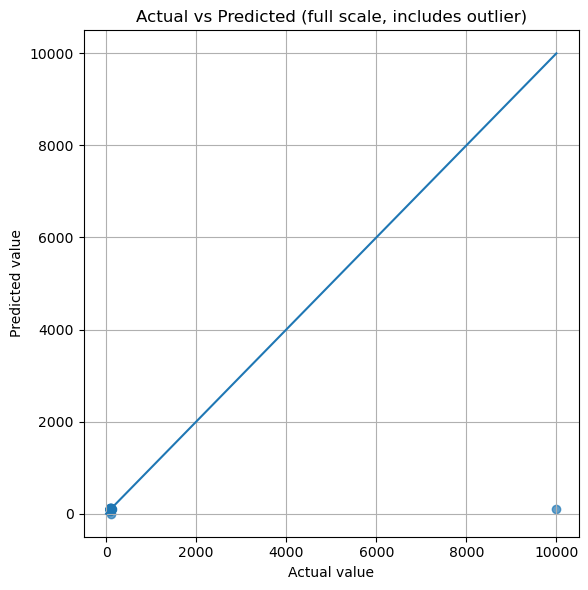

In [25]:
# Base data: cleaned numeric subset used for metrics
x = metrics_df["actual"]
y = metrics_df["predicted"]

# -----------------------------------------------------
# 1) Full scatter (includes outlier)
# -----------------------------------------------------

generate_plot(
    x,
    y,
    "Actual vs Predicted (full scale, includes outlier)"
)

> #### NOTES:
> Because we injected an extreme outlier (`actual_value = 9999`), the full-scale plot is dominated by it.  
> All other points appear compressed near the bottom-left corner.
>
> This is expected, and it motivates the use of a zoomed plot below.

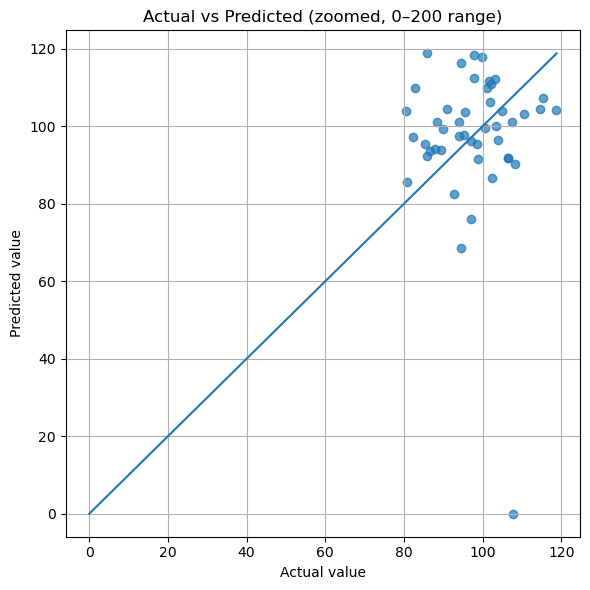

In [27]:
# -----------------------------------------------------
# 2) Zoomed scatter: exclude extreme values for visualization only
# -----------------------------------------------------

zoom_df = metrics_df[
    (metrics_df["actual"].between(0, 200)) &
    (metrics_df["predicted"].between(0, 200))
].copy()

x_zoom = zoom_df["actual"]
y_zoom = zoom_df["predicted"]

generate_plot(
    x_zoom,
    y_zoom,
    "Actual vs Predicted (zoomed, 0–200 range)"
)

> #### NOTES:
> - Points on the diagonal imply `predicted = actual`.
> - Points above the line (predicted > actual) → over-prediction.
> - Points below the line (predicted < actual) → under-prediction.
> 
> From the zoomed plot, we can see that:
> - Most points cluster around the `y = x` line, which is consistent with a model that is roughly centered around the actual values.
> - There is still visible noise, which is expected given how we generated the synthetic predictions.
> - The extreme outlier that we injected (`9999`) does not appear in the zoomed view, but it is still present in the data and is detected by the range and IQR checks above.
>
> In a real QA scenario, this kind of plot is often used alongside numerical metrics (MAE/RMSE) to quickly spot visual anomalies in model behaviour.

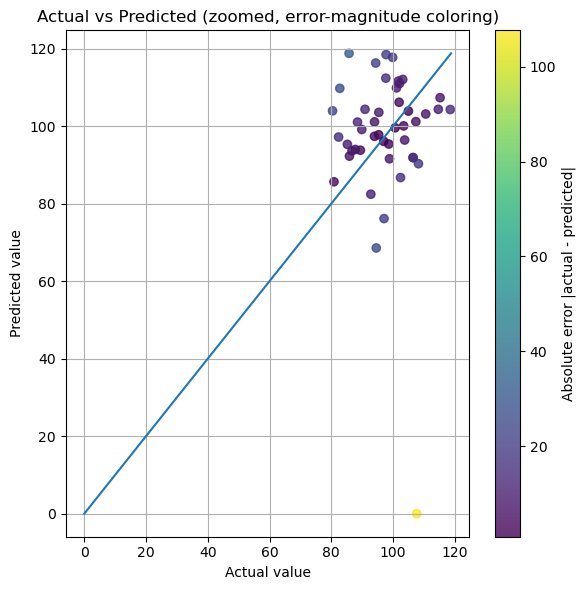

In [29]:
# -----------------------------------------------------
# 3) Error-colored scatter (zoomed to 0–200 range)
# -----------------------------------------------------

err = zoom_df["abs_error"]  # computed earlier

generate_plot(
    x_zoom,
    y_zoom,
    "Actual vs Predicted (zoomed, error-magnitude coloring)",
    err
)

> #### NOTES:
> This version of the zoomed scatter plot, colors each point by its absolute error:  
> `abs_error = |actual_value − predicted_value|`  
> (The colorbar on the right indicates the mapping from color to error magnitude.)
> 
> This makes it easy to see:
> - Which points have unusually large errors  
> - Whether large errors occur in a specific region  
> - Whether error magnitude is random or patterned
> 
> In practice, color-coded scatter plots often reveal subtle issues in model behavior that raw metrics cannot show.

---

## 8. Post-metric checks (outliers, metrics, stability)

Once basic checks, cleaning, and error metrics are computed, we add a second layer of QA checks that provide a more “end-to-end” validation of the data and metric behaviour.

These checks include:

- **IQR-based outlier fraction**: excessive statistical outliers may indicate data drift or corruption.
- **MAE / RMSE sanity bounds**: rough upper limits that help catch obvious accuracy failures.
- **Stability check vs history**: if historical metrics exist, today’s metrics should be in a reasonable range.

### Important notes (demo vs real world)

- Thresholds below are *demonstration-only* (they are intentionally loose). In a real project, they would be derived from business requirements or historical model performance.
- Outlier, metric and stability checks are implemented (deliberately) as **soft warnings**, so that the notebook runs end-to-end without stopping. In a real scenario these would typically be implemented as assertions (or alerting rules) that can fail a job or trigger an alert if the thresholds are violated.

In [32]:
print("\n=== LATE QA CHECKS (POST-METRICS) ===\n")

# -----------------------------------------------------
# 1) IQR outlier fraction (soft-warning)
# -----------------------------------------------------
iqr_frac_actual = iqr_outlier_fraction(df, "actual_value")
iqr_frac_pred = iqr_outlier_fraction(df, "predicted_value")

max_iqr_frac_actual = 0.15   # 15% (demo threshold)
max_iqr_frac_pred   = 0.20   # 20% (demo threshold)

if iqr_frac_actual > max_iqr_frac_actual:
    print(
        f"- [WARNING] actual_value has high IQR-outlier fraction: "
        f"{iqr_frac_actual:0.2%} (limit {max_iqr_frac_actual:0.2%})"
    )
else:
    print(
        f"- IQR outlier fraction OK for actual_value: "
        f"{iqr_frac_actual:0.2%} (limit {max_iqr_frac_actual:0.2%})"
    )

if iqr_frac_pred > max_iqr_frac_pred:
    print(
        f"- [WARNING] predicted_value has high IQR-outlier fraction: "
        f"{iqr_frac_pred:0.2%} (limit {max_iqr_frac_pred:0.2%})"
    )
else:
    print(
        f"- IQR outlier fraction OK for predicted_value: "
        f"{iqr_frac_pred:0.2%} (limit {max_iqr_frac_pred:0.2%})"
    )

# -----------------------------------------------------
# 2) Metric sanity (MAE / RMSE) – soft warnings for demo
# -----------------------------------------------------
max_mae  = 250    # demo cap
max_rmse = 400    # demo cap

if mae >= max_mae:
    print(f"- [WARNING] MAE unusually large: {mae:0.2f} (limit {max_mae})")
else:
    print(f"- MAE within expected range: {mae:0.2f} (limit {max_mae})")

if rmse >= max_rmse:
    print(
        f"- [WARNING] RMSE unusually large: {rmse:0.2f} (limit {max_rmse})"
        " – expected due to injected extreme outlier."
    )
else:
    print(f"- RMSE within expected range: {rmse:0.2f} (limit {max_rmse})")

# -----------------------------------------------------
# 3) Stability check vs history – soft warning
# -----------------------------------------------------
history_path = project_root / "data" / "metrics_history.csv"

if history_path.exists():
    history_df = pd.read_csv(history_path)

    if "mae" in history_df.columns:
        baseline_mae   = history_df["mae"].median()
        stability_limit = baseline_mae * 2

        if mae > stability_limit:
            print(
                f"\n- [WARNING] MAE unstable vs baseline: "
                f"current={mae:0.2f}, baseline≈{baseline_mae:0.2f}, "
                f"limit≈{stability_limit:0.2f}"
            )
        else:
            print(
                f"\n- Stability check passed: "
                f"current={mae:0.2f}, baseline≈{baseline_mae:0.2f}, "
                f"limit≈{stability_limit:0.2f}"
            )
    else:
        print("metrics_history.csv found but missing 'mae' column; skipping stability check.")

else:
    print("\nNo metrics_history.csv found; skipping stability check (demo).")

print("\nLate QA checks completed.")


=== LATE QA CHECKS (POST-METRICS) ===

- IQR outlier fraction OK for actual_value: 2.04% (limit 15.00%)
- IQR outlier fraction OK for predicted_value: 6.00% (limit 20.00%)
- MAE within expected range: 223.66 (limit 250)
- [WARNING] RMSE unusually large: 1444.90 (limit 400) – expected due to injected extreme outlier.

- [WARNING] MAE unstable vs baseline: current=223.66, baseline≈7.50, limit≈15.00

Late QA checks completed.


---

## 9. Summary (QA view)

In this notebook, we walked through a practical, QA-oriented workflow for validating a small regression-style dataset. The goal was not to build a model, but to demonstrate how data can be inspected, cleaned, and monitored using simple but effective quality checks.

### What we covered

- **Synthetic dataset creation**  
  Built a small actual vs predicted dataset for controlled experimentation.

- **Injection of realistic data issues**  
  Added missing values, empty strings, type corruption, infinities, a large outlier, and a duplicate row to simulate the kinds of issues that appear in real datasets.

- **Basic structural checks**  
  Verified shape, raw missingness, and duplicate counts—first indicators of data health.

- **Reusable validation helpers**  
  Applied standardized checks for numeric columns (invalid strings, infinities, booleans, negatives, and zero-handling).

- **Numeric conversion + profiling**  
  Safely coerced columns to numeric and used `describe()` to obtain a statistical profile of the cleaned dataset.

- **Outlier detection**  
  Used two complementary methods:  
  - **Rule-based range checks** for known valid boundaries  
  - **IQR-based detection** for statistical anomalies

- **Error metrics (MAE, RMSE)**  
  Computed accuracy metrics on a cleaned subset of rows and visualized the results with scatter plots.

- **Early and late QA checks**  
  Encoded expectations using assertions (schema/completeness) and soft warnings (outliers, metric bounds, stability).

### Final note

In real workflows, checks like these are typically automated as **data-quality assertions**, **monitoring thresholds**, or **pipeline gates**. For this demonstration, we surface most issues as **warnings** so that the notebook runs end-to-end while still showing what each QA guardrail would catch.

This provides a clear example of how QA-focused validation can help ensure data quality, detect anomalies early, and support more reliable downstream analysis or modeling.